# Structure function (and other statistics) for NGC 346 MUSE map

In [1]:
import numpy as np
from astropy.io import fits

In [2]:
import sys
sys.path.append("../muse-strucfunc")
import strucfunc


Load the moment maps from FITS files

In [3]:
hdu = fits.open("data/NGC346/ngc346-hi-6563-bin01-vmean.fits")
hdu.info()

Filename: data/NGC346/ngc346-hi-6563-bin01-vmean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1953   ()      
  1  DATA          1 ImageHDU        40   (346, 326)   float32   
  2  STAT          1 ImageHDU        40   (346, 326)   float32   


In [12]:
vha = hdu["DATA"].data.astype("float")

In [19]:
iha = fits.open(
    "data/NGC346/ngc346-hi-6563-bin01-vmean.fits"
)["DATA"].data.astype("float")

Note that we explicitly set the dtype because MPDAF saves the FITS files in 32-bit format to save space, but my strucfunc library requires default floats. 

Now, deal with bad pixels.  Set velocities to the mean and intenisty to zero.

In [20]:
m = ~np.isfinite(iha * vha) | (iha < 0.0)
iha[m] = 0.0
vha[m] = np.nanmean(vha)
iha /= iha.max()

## Hα structure function

### Calculate the structure function

In [22]:
sf = strucfunc.strucfunc_numba_parallel(vha, wmap=iha)

In [23]:
sf

{'log10 r': array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 ]),
 'Sum dv^2': array([1.72549909e+05, 6.06096030e+05, 2.12603202e+06, 7.09808637e+06,
        2.18602037e+07, 5.86069126e+07, 1.64325788e+08, 3.99954576e+08,
        9.66843788e+08, 2.27012301e+09, 5.30361394e+09, 1.18002418e+10,
        2.44596794e+10, 4.84580822e+10, 8.20774248e+10, 9.88151205e+10,
        6.75216964e+10]),
 'Sum weights': array([7.55637906e+04, 1.50741791e+05, 3.75728977e+05, 8.22637753e+05,
        1.78464690e+06, 3.39121273e+06, 7.29269069e+06, 1.37723208e+07,
        2.71574191e+07, 5.20925373e+07, 1.00680289e+08, 1.87397150e+08,
        3.36754552e+08, 5.71825028e+08, 8.79807705e+08, 1.08539305e+09,
        6.49717216e+08]),
 'Sum w * dv^2': array([1.29744297e+05, 4.55124210e+05, 1.59587167e+06, 5.31716089e+06,
        1.63083005e+07, 4.35367974e+07, 1.21671404e+08, 2.95523084e+08,
        7.13228962e+08, 1.67121255e+09, 3.89675407e+09

In [31]:
sig2 = np.var(vha)
sig2

29.535569331405828

In [45]:
good = (~m) & (iha > 0.001)
sf["Unweighted mean velocity"] = np.mean(vha[good])
sf["Unweighted sigma^2"] = np.var(vha[good])
v0w = sf["Weighted mean velocity"] = np.average(vha, weights=iha)
sf["Weighted sigma^2"] = np.average((vha - v0w)**2, weights=iha)


In [48]:
{k: sf[k] for k in sf if "sigma" in k or "mean" in k}

{'Unweighted mean velocity': 166.113623219373,
 'Unweighted sigma^2': 31.87910585532852,
 'Weighted mean velocity': 166.30553466671546,
 'Weighted sigma^2': 32.16184898926429}

In [33]:
import astropy.units as u

Convert pixels to parsecs at distance to SMC:

In [35]:
D = 61.7 * u.kpc
pix_pc = (0.2 * (D / u.pc) * u.au).to(u.pc)
pix_pc

<Quantity 0.05982601 pc>

In [36]:
sf["sep, pc"] = 10**sf["log10 r"] * pix_pc.value

### Plot the Hα structure function

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

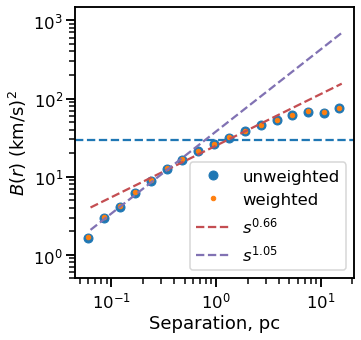

In [105]:
fig, ax = plt.subplots(figsize=(5, 5))
rgrid = np.logspace(
    np.log10(sf["sep, pc"][0]),
    np.log10(sf["sep, pc"][-1]),
    200
)
    
ax.plot(
    "sep, pc", "Unweighted B(r)", data=sf,
    linestyle="none",
    marker="o", label="unweighted",
)
ax.plot(
    "sep, pc", "Weighted B(r)", data=sf,
    linestyle="none",
    marker=".", label="weighted",
)
ax.axhline(sig2, linestyle="dashed")

rgrid = np.logspace(-1.2, 1.2)
mm = 0.66
ax.plot(
    rgrid, 25*rgrid**mm,
    color="r", linestyle="dashed",
    label=fr"$s^{{{mm}}}$",
)
mm = 1.05
ax.plot(
    rgrid, 38*rgrid**mm,
    color="m", linestyle="dashed",
    label=fr"$s^{{{mm}}}$",
)

ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r)$ (km/s)$^2$",
    ylim=[0.5, 1.5e3],
);

I am using the same y-axis scale as for 30 Dor.  The structure function starts off the same at small separations, but levels off at a much lower value.

Strangely, the weighted and unweighted values are almost identical. 

### Save the Hα structure function to JSON file

This is so we can do a better version of the plot later (as in tarantula-strucfunc-plot-ha.pdf)

In [50]:
import json

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
jsonfilename = f"ngc346-strucfunc-ha.json"
with open(jsonfilename, "w") as f:
    json.dump(sf, fp=f, indent=3, cls=MyEncoder)



### Hα structure function conclusions

The correlation length is about 1.5 pc. 

The plane-of-sky sigma is 5.65 km/s

These are consistent with the trends of our other sources, given the size and luminosity of NGC 346.

## [S II] structure function

In [54]:
isii = fits.open(
    "data/NGC346/ngc346-sii-6716-bin01-sum.fits"
)["DATA"].data.astype("float")
vsii = fits.open(
    "data/NGC346/ngc346-sii-6716-bin01-vmean.fits"
)["DATA"].data.astype("float")



In [55]:
m = ~np.isfinite(isii * vsii) | (isii < 0.0)
isii[m] = 0.0
vsii[m] = np.nanmean(vsii)
isii /= isii.max()

In [70]:
sf_sii = strucfunc.strucfunc_numba_parallel(
    vsii, 
    wmap=isii
)

In [71]:
good = (~m) & (isii > 0.001)
sf_sii["Unweighted mean velocity"] = np.mean(vsii[good])
sf_sii["Unweighted sigma^2"] = np.var(vsii[good])
v0w = sf_sii["Weighted mean velocity"] = np.average(
    vsii, weights=isii
)
sf_sii["Weighted sigma^2"] = np.average(
    (vsii - v0w)**2, 
    weights=isii
)

In [72]:
{k: sf_sii[k] for k in sf_sii 
 if "sigma" in k or "mean" in k}

{'Unweighted mean velocity': 163.5223681237438,
 'Unweighted sigma^2': 59.20581667307733,
 'Weighted mean velocity': 162.0136622998067,
 'Weighted sigma^2': 63.51708462238277}

In [73]:
sf_sii["sep, pc"] = 10**sf_sii["log10 r"] * pix_pc.value

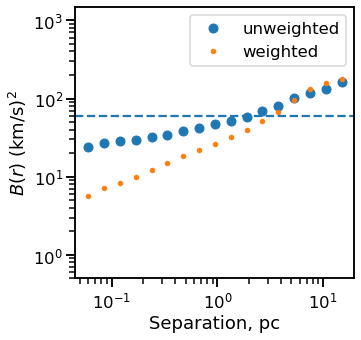

In [74]:
fig, ax = plt.subplots(figsize=(5, 5))
    
ax.plot(
    "sep, pc", "Unweighted B(r)", data=sf_sii,
    linestyle="none",
    marker="o", label="unweighted",
)
ax.plot(
    "sep, pc", "Weighted B(r)", data=sf_sii,
    linestyle="none",
    marker=".", label="weighted",
)
ax.axhline(sf_sii["Unweighted sigma^2"], 
           linestyle="dashed",
          )
ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r)$ (km/s)$^2$",
    ylim=[0.5, 1.5e3],
);

In [75]:
jsonfilename = f"ngc346-strucfunc-sii.json"
with open(jsonfilename, "w") as f:
    json.dump(sf_sii, fp=f, indent=3, cls=MyEncoder)

This is a lot flatter than the Hα version.  Lots of this is due to noise at the smallest scale.

We can try and correct that by just subtracting it off:

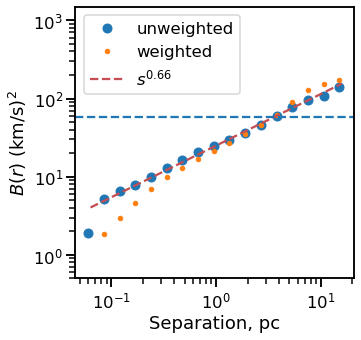

In [96]:
fig, ax = plt.subplots(figsize=(5, 5))

sep = sf_sii["sep, pc"]

# Assume fraction `frac` of variation at small scales is noise
bu0 = sf_sii["Unweighted B(r)"][0]
bw0 = sf_sii["Weighted B(r)"][0]
frac = 0.92
bu = sf_sii["Unweighted B(r)"] - frac*bu0
bw = sf_sii["Weighted B(r)"] - frac*bw0

ax.plot(
    sep, bu,
    linestyle="none",
    marker="o", label="unweighted",
)
ax.plot(
    sep, bw,
    linestyle="none",
    marker=".", label="weighted",
)
rgrid = np.logspace(-1.2, 1.2)
mm = 0.66
ax.plot(
    rgrid, 25*rgrid**mm,
    color="r", linestyle="dashed",
    label=fr"$s^{{{mm}}}$",
)

sig2_sii = sf_sii["Unweighted sigma^2"] - 0.5*frac*bu[0]
ax.axhline(
    sig2_sii, 
    linestyle="dashed",
)
ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Separation, pc",
    ylabel=r"$B(r)$ (km/s)$^2$",
    ylim=[0.5, 1.5e3],
);

In [97]:
np.sqrt(sig2_sii)

7.637564430556536

By subtracting just the right amount of noise, it is possible to make the unweighted [S II] structure function into a perfect straight line! 

(I am assuming a 92% noise contribution to the observed strucfunc at the smallest separation). 

The fact that it keeps climbing at all scales implies that the true correlation length is larger than the FOV of the observations.

*But this also implies that the true $\sigma$ is larger than the value that we measure*